In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchmetrics.functional.regression import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)


In [13]:
filename = "../DATA/oil_price.csv"
priceDF = pd.read_csv(filename, encoding="utf-8", parse_dates=["date"])
priceDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7291 entries, 0 to 7290
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7291 non-null   datetime64[ns]
 1   price   7291 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 114.0 KB


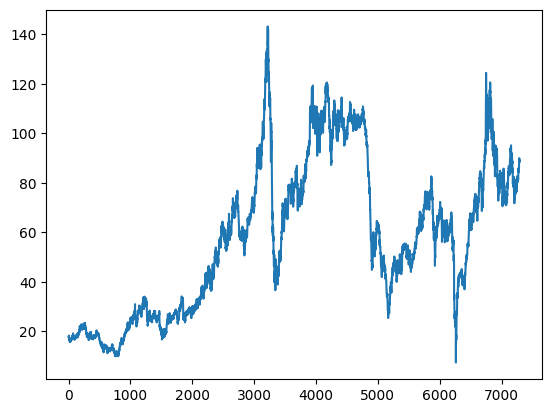

In [14]:
plt.plot(priceDF["price"], label="price")
plt.show()


In [15]:
class OilPriceDataset(Dataset):
    def __init__(self, data, step=30):
        data = data if isinstance(data, np.ndarray) else data.values
        self.max_data = np.max(data)
        self.min_data = np.min(data)
        self.data = (data - self.min_data) / (self.max_data - self.min_data)
        self.data = torch.FloatTensor(self.data)
        self.step = step

    def __len__(self):
        return len(self.data) - self.step

    def __getitem__(self, i):
        data = self.data[i : i + self.step]
        label = self.data[i + self.step]
        return data, label


In [53]:
class OilPriceModel(nn.Module):
    def __init__(self, hidden_size, num_layers, step=30):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=step,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return torch.flatten(x)


In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_size = 30
num_layers = 2
step = 365
batch_size = 32

model = OilPriceModel(hidden_size, num_layers, step).to(device)
dataset = OilPriceDataset(priceDF["price"], step)
loader = DataLoader(dataset, batch_size)
optimizer = optim.AdamW(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

len(loader)


227

In [72]:
def learning(
    epochs, epoch, model, loader, optimizer, loss_fn, is_train=True, use_pbar=True
):
    if is_train:
        model.train()
    else:
        model.eval()

    lossList, maeList, mseList, r2List = [], [], [], []
    with torch.set_grad_enabled(is_train):
        pbar = tqdm(loader, total=len(loader)) if use_pbar else loader
        for data, label in pbar:
            pred = model(data.to(device))
            loss = loss_fn(pred, label.to(device))
            lossList.append(loss.item())
            maeList.append(mean_absolute_error(pred, label.to(device)).item())
            mseList.append(mean_squared_error(pred, label.to(device)).item())
            r2List.append(r2_score(pred, label.to(device)).item())
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if use_pbar:
                    pbar.set_description(
                        f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.6f}"
                    )
    return np.mean(lossList), np.mean(maeList), np.mean(mseList), np.mean(r2List)


In [57]:
pre_r2 = 0
pre_loss = 100


In [73]:
epochs = 1000
for epoch in range(epochs):
    loss, mae, mse, r2 = learning(
        epochs, epoch, model, loader, optimizer, loss_fn, is_train=True, use_pbar=True
    )
    if epoch % 10 == 9:
        print(
            f"  ==== Loss: {loss:.6f} | MAE: {mae:.6f} | MSE: {mse:.6f} | R2: {r2:.6f} ===="
        )
    if pre_r2 < r2 or (pre_r2 <= r2 and pre_loss > loss):
        torch.save(model, "oil_price_model_365.pth")
        torch.save(model.state_dict(), "oil_price_model_state_365.pth")
        print(f"Model Saved! => R2: {r2:.6f} | Loss: {loss:.6f}")
        pre_r2 = r2
        pre_loss = loss
    scheduler.step(loss)


  ==== Loss: 0.007972 | MAE: 0.006002 | MSE: 0.000082 | R2: 0.608772 ====
  ==== Loss: 0.007966 | MAE: 0.005998 | MSE: 0.000082 | R2: 0.609328 ====
  ==== Loss: 0.007961 | MAE: 0.005994 | MSE: 0.000082 | R2: 0.609881 ====
  ==== Loss: 0.007956 | MAE: 0.005990 | MSE: 0.000082 | R2: 0.610426 ====
  ==== Loss: 0.007950 | MAE: 0.005986 | MSE: 0.000082 | R2: 0.610967 ====
  ==== Loss: 0.007945 | MAE: 0.005982 | MSE: 0.000081 | R2: 0.611506 ====
  ==== Loss: 0.007940 | MAE: 0.005978 | MSE: 0.000081 | R2: 0.612038 ====
  ==== Loss: 0.007935 | MAE: 0.005974 | MSE: 0.000081 | R2: 0.612567 ====
  ==== Loss: 0.007930 | MAE: 0.005971 | MSE: 0.000081 | R2: 0.613093 ====
  ==== Loss: 0.007924 | MAE: 0.005967 | MSE: 0.000081 | R2: 0.613613 ====
  ==== Loss: 0.007919 | MAE: 0.005963 | MSE: 0.000081 | R2: 0.614133 ====
  ==== Loss: 0.007914 | MAE: 0.005959 | MSE: 0.000081 | R2: 0.614646 ====
  ==== Loss: 0.007909 | MAE: 0.005956 | MSE: 0.000081 | R2: 0.615159 ====
  ==== Loss: 0.007904 | MAE: 0.005952 

In [74]:
pre_r2, r2


(0.6977363664673288, 0.697736249621219)

In [75]:
pred_loader = DataLoader(dataset, batch_size=1)
preds = []  # 예측값들을 저장하는 리스트
total_loss = 0
pred_model = torch.load("oil_price_model.pth")
with torch.no_grad():
    for data, label in pred_loader:
        # 모델의 예측값 출력
        pred = model(data)
        preds.append(pred.item())
        loss = loss_fn(pred, label.to(device))
        total_loss += loss / len(loader)


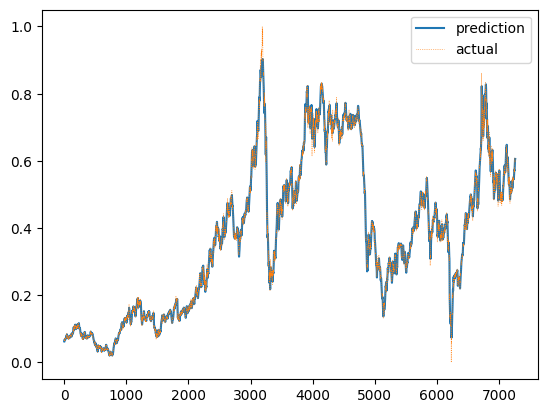

In [76]:
plt.plot(preds, label="prediction")
plt.plot(dataset.data[step:], label="actual", ls=":", lw=0.5)
plt.legend()
plt.show()


In [77]:
preds = []  # 예측값들을 저장하는 리스트
pred_model = torch.load("oil_price_model.pth")
start = dataset[0][0]
with torch.no_grad():
    for i in range(8000):
        pred = pred_model(start.unsqueeze(0))
        start = torch.cat((start[1:], pred))
        preds.append(pred.item())


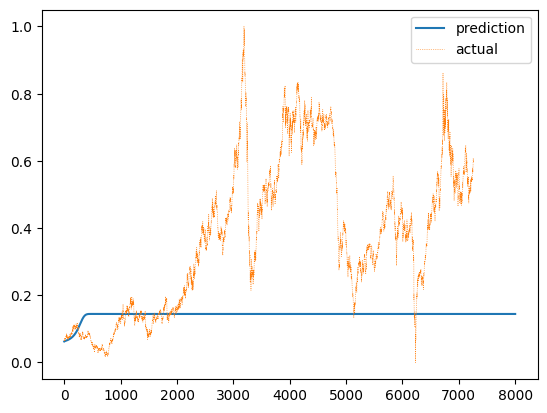

In [78]:
plt.plot(preds, label="prediction")
plt.plot(dataset.data[step:], label="actual", ls=":", lw=0.5)
plt.legend()
plt.show()
